# Import data from yfinance

In [2]:
import yfinance as yf

In [3]:
# Get the data for the stock portfolio
portfolio = yf.Tickers('AMD')

# Get the historical data for the stock portfolio
hist = portfolio.history(start='2020-01-01', period='5y')


[*********************100%***********************]  1 of 1 completed


In [4]:
hist_amd = hist.xs('AMD', axis=1, level=1)
hist_amd

Price,Close,Dividends,High,Low,Open,Stock Splits,Volume
Date,,,,,,,
2020-01-02,49.099998,0.0,49.250000,46.630001,46.860001,0.0,80331100
2020-01-03,48.599998,0.0,49.389999,47.540001,48.029999,0.0,73127400
2020-01-06,48.389999,0.0,48.860001,47.860001,48.020000,0.0,47934900
2020-01-07,48.250000,0.0,49.389999,48.040001,49.349998,0.0,58061400
2020-01-08,47.830002,0.0,48.299999,47.139999,47.849998,0.0,53767000
...,...,...,...,...,...,...,...
2024-12-24,126.290001,0.0,127.510002,124.660004,127.510002,0.0,24829600
2024-12-26,125.059998,0.0,127.300003,125.050003,125.519997,0.0,24998200
2024-12-27,125.190002,0.0,126.180000,122.260002,124.370003,0.0,32924000


backtesting

In [5]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(hist_amd, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
bt.plot()

/Users/ivanlee/Developer/financial-data-toolkit/.venv/lib/python3.13/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_10155/1382971500.py:22: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run()


GridPlot(id='p1356', ...)

## Date-based buy/sell strategy
Given lists of buy and sell dates (we buy/sell the whole portfolio on those dates),
this Strategy maps the provided calendar dates to the nearest bars present in the OHLC data and
issues full-portfolio buys and full closes on matching bars.

Notes:
- Provide `buy_dates` and `sell_dates` as lists of date-like strings or pd.Timestamp objects when calling `Backtest.run(...)`.
- Dates that don't fall on trading days are matched by calendar date against available data index entries (i.e. the strategy finds bars whose normalized date equals the provided date).

In [6]:
from backtesting import Strategy
import pandas as pd

class DateStrategy(Strategy):
    # declare parameters so Backtest.run can override them
    buy_dates = None
    sell_dates = None

    def init(self):
        # Normalize incoming date lists to pandas.Timestamp (date-only) for robust matching
        # Accept None, list of strings, or list of Timestamp-like objects
        self._buy_dates = set(pd.to_datetime(self.buy_dates).normalize()) if self.buy_dates is not None else set()
        self._sell_dates = set(pd.to_datetime(self.sell_dates).normalize()) if self.sell_dates is not None else set()

        # Map provided dates to actual timestamps present in the OHLC index so we only trigger on available bars
        idx = pd.to_datetime(self.data.index)
        self._buy_bars = set(ts for ts in idx if ts.normalize() in self._buy_dates)
        self._sell_bars = set(ts for ts in idx if ts.normalize() in self._sell_dates)

    def next(self):
        # Current (most recent) bar timestamp available inside next()
        now = self.data.index[-1]

        # BUY whole portfolio if today is a buy-bar and we are flat
        if now in self._buy_bars:
            if not self.position:
                # buy full equity (default size behavior)
                self.buy()

        # SELL / close whole portfolio if today is a sell-bar and we have a position
        elif now in self._sell_bars:
            if self.position:
                # close entire position
                self.position.close()

# End of DateStrategy

In [7]:
# Example: run the date-driven strategy using the `hist_amd` dataframe already present in this notebook
# Replace the example buy/sell dates below with your actual lists.
from backtesting import Backtest

# Example buy/sell dates (calendar dates). Use YYYY-MM-DD strings or Timestamps.
buy_dates = ['2020-02-03', '2020-08-10', '2021-01-04', '2022-05-12']
sell_dates = ['2020-05-01', '2020-12-15', '2021-03-01']

# Create Backtest. Use exclusive_orders=True to ensure single position at a time.
bt = Backtest(hist_amd, DateStrategy, cash=10_000, exclusive_orders=True, finalize_trades=True)
stats = bt.run(buy_dates=buy_dates, sell_dates=sell_dates)
display(stats)
# print(stats[['Start', 'End', '# Trades', 'Equity Final [$]']])

# Optional: show interactive plot (will open a browser window)
bt.plot()

Start                     2020-01-02 00:00:00
End                       2024-12-31 00:00:00
Duration                   1825 days 00:00:00
Exposure Time [%]                    67.88553
Equity Final [$]                  16005.31972
Equity Peak [$]                   27481.72055
Return [%]                            60.0532
Buy & Hold Return [%]               146.00816
Return (Ann.) [%]                     9.87979
Volatility (Ann.) [%]                 49.8864
CAGR [%]                              6.71004
Sharpe Ratio                          0.19805
Sortino Ratio                         0.33223
Calmar Ratio                           0.2038
Alpha [%]                           -40.23157
Beta                                  0.68684
Max. Drawdown [%]                   -48.47716
Avg. Drawdown [%]                   -11.10222
Max. Drawdown Duration      491 days 00:00:00
Avg. Drawdown Duration       89 days 00:00:00
# Trades                                    4
Win Rate [%]                      

GridPlot(id='p1715', ...)

# Regime Detection

## Gaussian Mixture Model

In [13]:
# call spy data for last 10 years
spy = yf.Ticker('SPY')
hist_spy = spy.history(start='2000-01-01')
hist_spy

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2000-01-03 00:00:00-05:00,93.924435,93.924435,91.152634,92.142563,8164300,0.0,0.0,0.0
2000-01-04 00:00:00-05:00,90.934811,91.271387,88.469890,88.539185,8089800,0.0,0.0,0.0
2000-01-05 00:00:00-05:00,88.658027,89.667754,86.955349,88.697624,12177900,0.0,0.0,0.0
2000-01-06 00:00:00-05:00,88.459986,89.647900,87.272072,87.272072,6227200,0.0,0.0,0.0
2000-01-07 00:00:00-05:00,88.895565,92.340515,88.737176,92.340515,8066500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2025-09-03 00:00:00-04:00,642.669983,644.210022,640.460022,643.739990,70820900,0.0,0.0,0.0
2025-09-04 00:00:00-04:00,644.419983,649.150024,643.510010,649.119995,65219200,0.0,0.0,0.0
2025-09-05 00:00:00-04:00,651.479980,652.210022,643.330017,647.239990,85178900,0.0,0.0,0.0


In [17]:
# calculate daily returns
hist_spy['Daily Return'] = hist_spy['Close'].pct_change()
hist_spy
# calculate weekly returns
hist_spy['Weekly Return'] = hist_spy['Close'].pct_change(5)
hist_spy

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Daily Return,Weekly Return
Date,,,,,,,,,,
2000-01-03 00:00:00-05:00,93.924435,93.924435,91.152634,92.142563,8164300,0.0,0.0,0.0,NaN,NaN
2000-01-04 00:00:00-05:00,90.934811,91.271387,88.469890,88.539185,8089800,0.0,0.0,0.0,-0.039107,NaN
2000-01-05 00:00:00-05:00,88.658027,89.667754,86.955349,88.697624,12177900,0.0,0.0,0.0,0.001789,NaN
2000-01-06 00:00:00-05:00,88.459986,89.647900,87.272072,87.272072,6227200,0.0,0.0,0.0,-0.016072,NaN
2000-01-07 00:00:00-05:00,88.895565,92.340515,88.737176,92.340515,8066500,0.0,0.0,0.0,0.058076,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-09-03 00:00:00-04:00,642.669983,644.210022,640.460022,643.739990,70820900,0.0,0.0,0.0,0.005420,-0.002201
2025-09-04 00:00:00-04:00,644.419983,649.150024,643.510010,649.119995,65219200,0.0,0.0,0.0,0.008357,0.003851
2025-09-05 00:00:00-04:00,651.479980,652.210022,643.330017,647.239990,85178900,0.0,0.0,0.0,-0.002896,-0.002589


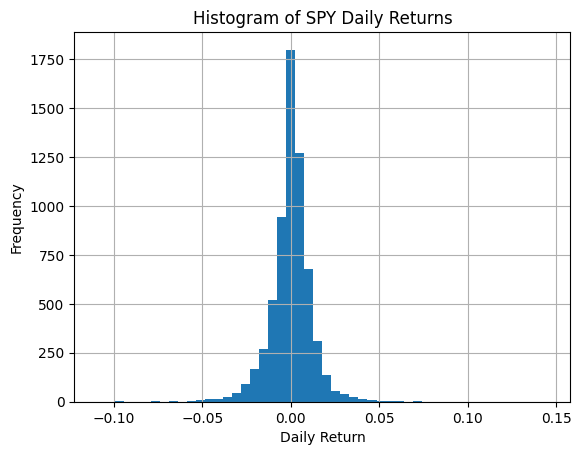

In [ ]:
# plot the daily returns on a frequency histogram
import matplotlib.pyplot as plt
hist_spy['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Histogram of SPY Daily Returns')
plt.show()


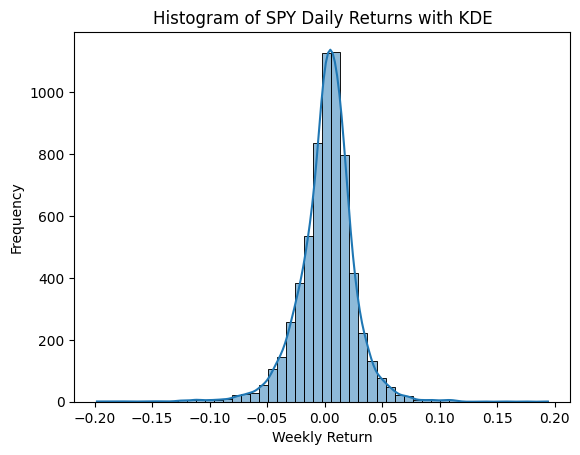

In [18]:
# check if it follows a gaussian mixture model
import seaborn as sns
sns.histplot(hist_spy['Weekly Return'].dropna(), bins=50, kde=True)
plt.xlabel('Weekly Return')
plt.ylabel('Frequency')
plt.title('Histogram of SPY Daily Returns with KDE')
plt.show()

## Hidden Markov Model

In [20]:
# use a hidden markov model to fit the data
from hmmlearn.hmm import GaussianHMM
import numpy as np

# fit the model to the weekly returns
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
# reshape the data
returns = hist_spy['Weekly Return'].dropna().values.reshape(-1, 1)
model.fit(returns)
# predict the hidden states
hidden_states = model.predict(returns)
# add the hidden states to the dataframe
hist_spy = hist_spy.dropna()
hist_spy['Hidden State'] = hidden_states
hist_spy


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Daily Return,Weekly Return,Hidden State
Date,,,,,,,,,,,
2000-01-10 00:00:00-05:00,92.657265,93.073034,91.885121,92.657265,5741700,0.0,0.0,0.0,0.003430,0.005586,0
2000-01-11 00:00:00-05:00,92.380108,92.558296,90.915015,91.548569,7503700,0.0,0.0,0.0,-0.011966,0.033989,0
2000-01-12 00:00:00-05:00,91.607947,91.607947,90.519026,90.637817,6907700,0.0,0.0,0.0,-0.009948,0.021874,0
2000-01-13 00:00:00-05:00,91.528720,92.340461,90.776375,91.865295,5158300,0.0,0.0,0.0,0.013543,0.052631,0
2000-01-14 00:00:00-05:00,92.835461,93.429417,92.479086,93.112640,7437300,0.0,0.0,0.0,0.013578,0.008362,0
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-03 00:00:00-04:00,642.669983,644.210022,640.460022,643.739990,70820900,0.0,0.0,0.0,0.005420,-0.002201,2
2025-09-04 00:00:00-04:00,644.419983,649.150024,643.510010,649.119995,65219200,0.0,0.0,0.0,0.008357,0.003851,2
2025-09-05 00:00:00-04:00,651.479980,652.210022,643.330017,647.239990,85178900,0.0,0.0,0.0,-0.002896,-0.002589,2


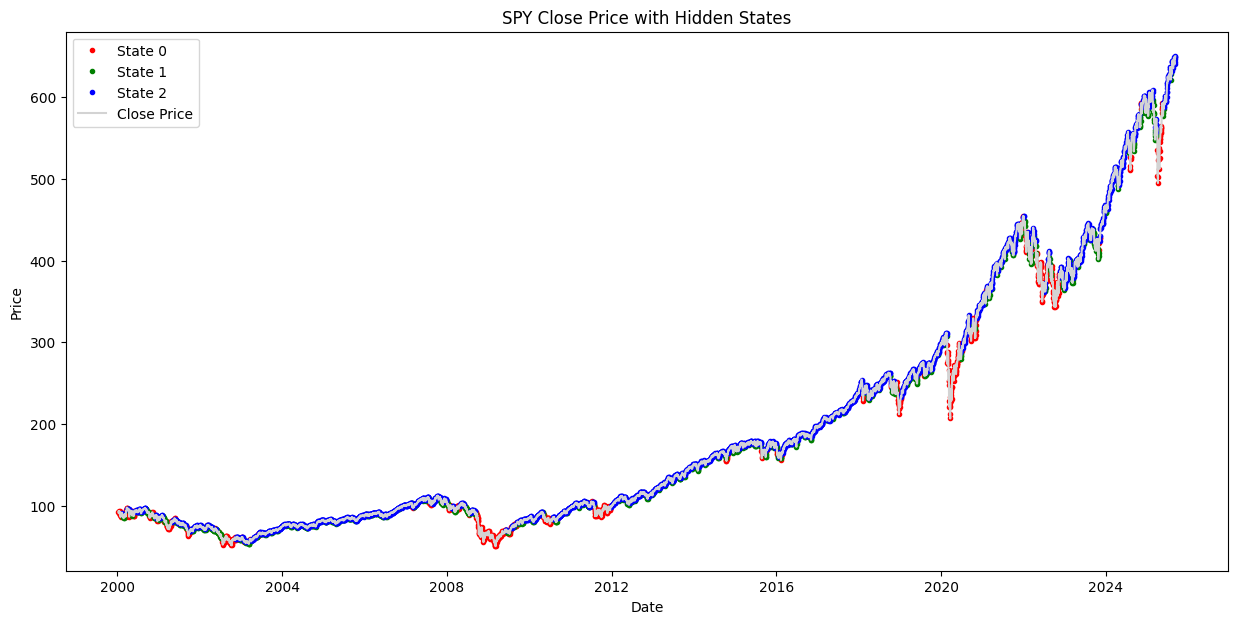

In [23]:
# plot the hidden states as colours on a time series
import matplotlib.pyplot as plt
import numpy as np
# colour each point by its hidden state
colors = np.array(['red', 'green', 'blue'])
plt.figure(figsize=(15, 7))
for i in range(model.n_components):
    state = hist_spy['Hidden State'] == i
    plt.plot(hist_spy.index[state], hist_spy['Close'][state], '.', color=colors[i], label=f'State {i}')
plt.plot(hist_spy.index, hist_spy['Close'], '-', color='lightgrey', label='Close Price')
plt.title('SPY Close Price with Hidden States')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [24]:
# use a hidden markov model to fit the data daily
from hmmlearn.hmm import GaussianHMM
import numpy as np

# fit the model to the weekly returns
model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000)
# reshape the data
returns = hist_spy['Daily Return'].dropna().values.reshape(-1, 1)
model.fit(returns)
# predict the hidden states
hidden_states = model.predict(returns)
# add the hidden states to the dataframe
hist_spy = hist_spy.dropna()
hist_spy['Hidden State'] = hidden_states
hist_spy


Model is not converging.  Current: 20649.667725089435 is not greater than 20649.667879192486. Delta is -0.00015410305059049278


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Daily Return,Weekly Return,Hidden State
Date,,,,,,,,,,,
2000-01-10 00:00:00-05:00,92.657265,93.073034,91.885121,92.657265,5741700,0.0,0.0,0.0,0.003430,0.005586,2
2000-01-11 00:00:00-05:00,92.380108,92.558296,90.915015,91.548569,7503700,0.0,0.0,0.0,-0.011966,0.033989,2
2000-01-12 00:00:00-05:00,91.607947,91.607947,90.519026,90.637817,6907700,0.0,0.0,0.0,-0.009948,0.021874,2
2000-01-13 00:00:00-05:00,91.528720,92.340461,90.776375,91.865295,5158300,0.0,0.0,0.0,0.013543,0.052631,2
2000-01-14 00:00:00-05:00,92.835461,93.429417,92.479086,93.112640,7437300,0.0,0.0,0.0,0.013578,0.008362,2
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-03 00:00:00-04:00,642.669983,644.210022,640.460022,643.739990,70820900,0.0,0.0,0.0,0.005420,-0.002201,0
2025-09-04 00:00:00-04:00,644.419983,649.150024,643.510010,649.119995,65219200,0.0,0.0,0.0,0.008357,0.003851,0
2025-09-05 00:00:00-04:00,651.479980,652.210022,643.330017,647.239990,85178900,0.0,0.0,0.0,-0.002896,-0.002589,0


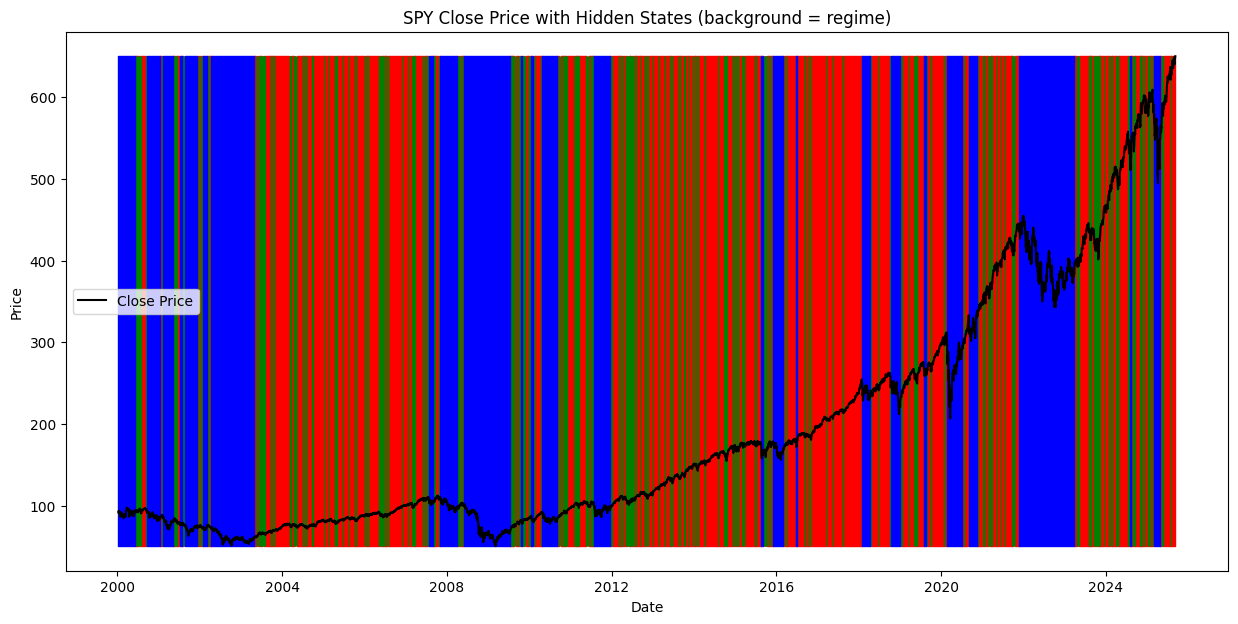

In [33]:
# plot the hidden states as colours on a time series, with background color for regimes
plt.figure(figsize=(15, 7))
# for i in range(model.n_components):
#     state = hist_spy['Hidden State'] == i
#     plt.plot(hist_spy.index[state], hist_spy['Close'][state], '.', color=colors[i], label=f'State {i}')

plt.plot(hist_spy.index, hist_spy['Close'], '-', color='black', label='Close Price')

# Add background color for each regime
for i in range(model.n_components):
    mask = hist_spy['Hidden State'] == i
    plt.fill_between(hist_spy.index, hist_spy['Close'].min(), hist_spy['Close'].max(),
                     where=mask, color=colors[i], alpha=1)

plt.title('SPY Close Price with Hidden States (background = regime)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
